In [1]:
import pandas as pd

In [2]:
# loading data
df = pd.read_csv("attrition_data.csv")

# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
# take a look at columns to:
# 1- find the primary key col(s)
# 2- find the target col(s)
# 3- find non production cols

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
# 1- primary key col: 
primary_key_col = "EmployeeNumber"
# it doesn't contribute anything. It will be yeeted
df = df.drop(primary_key_col, axis=1)

# 2- target col
target_col = "Attrition"

# 3- non production col: none

In [ ]:
# chi-squared independence test
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_train[target_col], df_train[sample_categorical_col])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [ ]:
# train test split
from sklearn.model_selection import train_test_split, BaseCrossValidator

X = df.drop(target_col, axis=1)
y = df[target_col]

# dividing into train and val_test together
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=(0.1 + 0.1), random_state=42, stratify=y
)

# diving val_test into val and test separately
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=(0.1 / (0.1 + 0.1)), random_state=42, stratify=y_val_test
    )

df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# This is a nice comment.

In [ ]:
# pretty print the dataframe
print(df_train)

print(len(df_train))

In [8]:
# some EDA

# looking at number of rows
m, n = X_train.shape
C = y_train.nunique()
print(y_train.unique())

print(m, n, C)
print(m / n)

# null values
# There are no null values

# identifying numerical and categorical cols
numerical_cols = X_train.select_dtypes(include=["number"]).columns
categorical_cols = X_train.select_dtypes(include=["object"]).columns
print(len(numerical_cols))
print(len(categorical_cols))

['No' 'Yes']
1176 33 2
35.63636363636363
25
8


In [9]:
# outliers

sample_numerical_col = "Age"

summary = df_train[sample_numerical_col].describe()
minimum = summary["min"]
twenty_fifth = summary['25%']
median = summary['50%']
seventy_fith = summary['75%']
maximum = summary["max"]
iqr = seventy_fith - twenty_fifth
lower_extreme = twenty_fifth - 1.5 * iqr
upper_extreme = seventy_fith + 1.5 * iqr

lower_extreme, upper_extreme

(10.5, 62.5)

In [13]:
y_train.value_counts(normalize=True)

Attrition
No     0.838435
Yes    0.161565
Name: proportion, dtype: float64

In [ ]:
# checking for class imbalance
round(y_train.value_counts(normalize=True), 2)

# addressing class imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

print(round(y_under.value_counts(normalize=True), 2))

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_over, y_over = smote.fit_resample(X, y)

print(round(y_over.value_counts(normalize=True), 2))

Attrition
No     0.67
Yes    0.33
Name: proportion, dtype: float64
Attrition
No     0.5
Yes    0.5
Name: proportion, dtype: float64


In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_over)

# check if Yes is 1 and No is 0.
print("Class Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Class Mapping: {'No': 0, 'Yes': 1}


In [14]:
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [15]:
categorical_col_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

In [11]:
# FP: Model said an employee would be leaving, but the employee is not leaving
# FN: Model said the employee would not be leaving, but the employee left

# Assuming we're creating a reward system, it would be worse to reward an employee we think is staying
# but the employee is actually leaving. so let's try to minimize FN and maximimze recall.

In [16]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

In [17]:
from tqdm.auto import tqdm
from itertools import product

# iterations = [100, 300, 500]
# learning_rate = [0.01, 0.033, 0.1]
# depth = [2, 4, 6, 8, 10]
# l2_leaf_reg = [1, 3, 5]

iterations = [100, 300, 500]
learning_rate = [0.01, 0.033, 0.1]
depth = [2, 4]
l2_leaf_reg = [1, 3]

hps = list(product(iterations, learning_rate, depth, l2_leaf_reg))

trained_models = []
metrics = []

max_recall = 0.0

for it, lr, d, l2 in tqdm(hps, total=len(hps)):
    model = CatBoostClassifier(
        iterations=it,
        learning_rate=lr,
        depth=d,
        l2_leaf_reg=l2,
        cat_features=categorical_col_indices,
        verbose=0
    )
    model.fit(X_over, y_over)
    trained_models.append(model)
    y_pred = label_encoder.transform(model.predict(X_val))
    recall = recall_score(y_val, y_pred)
    if recall > max_recall:
        max_recall = recall
        print(f"new best recall = {max_recall}!")
    metrics.append(recall)

d:\ITI Instructor\Data Science Toolkit\code\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  3%|▎         | 1/36 [00:01<00:55,  1.58s/it]

new best recall = 0.5!


  6%|▌         | 2/36 [00:02<00:46,  1.36s/it]

new best recall = 0.5416666666666666!


 14%|█▍        | 5/36 [00:07<00:45,  1.47s/it]

new best recall = 0.5833333333333334!


 33%|███▎      | 12/36 [00:18<00:39,  1.63s/it]

new best recall = 0.625!


100%|██████████| 36/36 [02:20<00:00,  3.89s/it]


In [19]:
best_model = trained_models[metrics.index(max(metrics))]

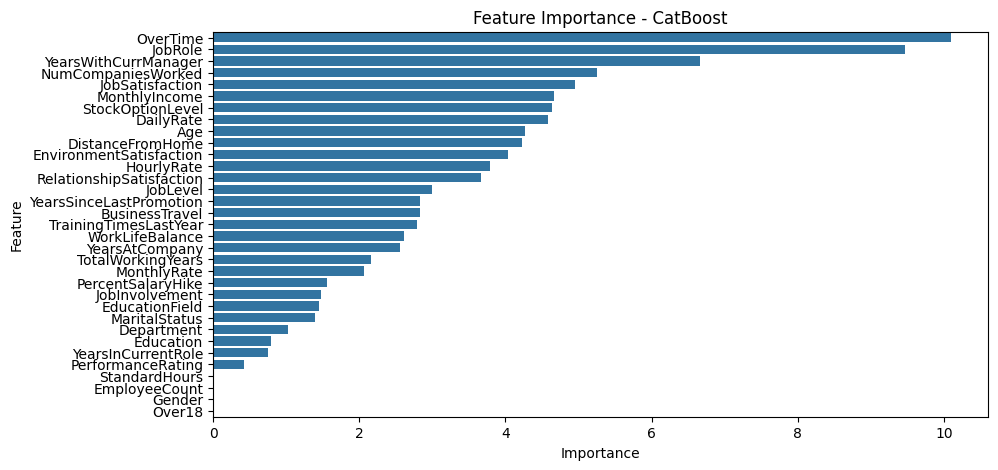

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns

# Create a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance - CatBoost")
plt.show()

In [21]:
y_pred = label_encoder.transform(best_model.predict(X_test))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("test data metrics")
print("accuracy:", round(accuracy, 2))
print("precision:", round(precision, 2))
print("recall:", round(recall, 2))
print("f1 score:", round(f1, 2))
print("auc score:", round(auc_score, 2))

test data metrics
accuracy: 0.8
precision: 0.41
recall: 0.61
f1 score: 0.49
auc score: 0.72
